In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

# load data
train = np.load('data/train.npz')
X, y = train['arr_0'], train['arr_1']
classes = ['ant', 'spider', 'flower', 'dolphin', 'lobster', 'bulldozer']

X_train, X_test, y_train, y_test = train_test_split(
    train['arr_0'], train['arr_1'], test_size=0.33, random_state=42)

# Parameter Tuning on Original Dataset

In [88]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
     
parameters = {'C': np.logspace(-4, 0, 5)}

clf = RandomizedSearchCV(LinearSVC(), parameters, n_iter=100, n_jobs=60, verbose=2)

clf.fit(X_train, y_train)

print(f'accuracy: {clf.best_score_:.3f}',
      f'\nbest parameters: { clf.best_params_}')

/apps/conda/pyanni/envs/kaggle_env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=60)]: Done  10 out of  25 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=60)]: Done  23 out of  25 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=60)]: Done  25 out of  25 | elapsed:    2.2s finished


accuracy: 0.351 
best parameters: {'C': 0.0001}


/apps/conda/pyanni/envs/kaggle_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [92]:
from sklearn.svm import SVC
     
parameters = {'C': np.linspace(0, 5, 10)}

clf = RandomizedSearchCV(SVC(), parameters, n_iter=100, n_jobs=60, verbose=2)

clf.fit(X_train, y_train)

print(f'accuracy: {clf.best_score_:.3f}',
      f'\nbest parameters: { clf.best_params_}')

/apps/conda/pyanni/envs/kaggle_env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=60)]: Done   9 out of  50 | elapsed:    1.5s remaining:    7.0s
[Parallel(n_jobs=60)]: Done  35 out of  50 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=60)]: Done  50 out of  50 | elapsed:    1.8s finished


accuracy: 0.544 
best parameters: {'C': 1.1111111111111112}


# Histogram of Oriented Gradients (HOG)
The principle of HOG is pretty clear, but I do not understand the parametrization on skimage. The best resource I found is https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/ but I still do not understand the output of hog (the shape doesn't make sense to me).

Next step: look into source code

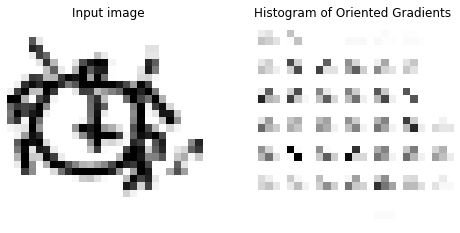

(28, 28)


In [79]:
from skimage.feature import hog
from skimage import data, exposure
from skimage.transform import resize


image = X[7].reshape(28, 28)

fd, hog_image = hog(image, visualize=True, pixels_per_cell=(4, 4))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap='gray_r')
ax1.set_title('Input image')

# Rescale histogram for better display
# hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image, cmap='gray_r')
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

print(hog_image.shape)

scaling (with StandardScaler) does not improve performance

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from skimage.feature import hog

def transform_hog(X):
    return np.array([hog(resize(x.reshape(28, 28), (32, 32))) for x in X])
    
    
pipe = Pipeline(
    [('transformer', FunctionTransformer(transform_hog)),
     ('SVC', SVC())])

parameters = {'SVC__kernel': ['rbf', 'linear'],
              'SVC__C': np.linspace(0, 2, 10)}
     
# parameters = {'SVC__C': np.linspace(0, 2, 10)}

clf = RandomizedSearchCV(pipe, parameters, n_iter=100, n_jobs=60, verbose=2)

clf.fit(X_train, y_train)

print(f'accuracy: {clf.best_score_:.3f}',
      f'\nbest parameters: { clf.best_params_}')

/apps/conda/pyanni/envs/kaggle_env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=60)]: Done  32 out of 100 | elapsed:    2.5s remaining:    5.2s
[Parallel(n_jobs=60)]: Done  83 out of 100 | elapsed:    3.7s remaining:    0.8s
[Parallel(n_jobs=60)]: Done 100 out of 100 | elapsed:    4.3s finished


accuracy: 0.646 
best parameters: {'SVC__kernel': 'rbf', 'SVC__C': 1.7777777777777777}


# Fit on Augmented Dataset
Rotations do not seem to increase accuracy (they actually decrease it).

In [6]:
from data_augmentation import AugmentData
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from skimage.feature import hog

def transform_hog(X):
    return np.array([hog(x.reshape(28, 28)) for x in X])

aug_data = AugmentData(X_train, y_train, classes)
aug_data.add_shifted_images([1, 2, 3])
aug_data.add_flipped_images()
X_train_aug, y_train_aug = aug_data.return_data()

fitted_pipe = Pipeline(
    [('transformer', FunctionTransformer(transform_hog)),
     ('SVC', SVC(C=1.77, kernel='rbf'))])

fitted_pipe.fit(X_train_aug, y_train_aug)

from sklearn.metrics import accuracy_score
y_pred = fitted_pipe.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6585858585858586


In [7]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_test, y_pred, classes):
    df_report = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize='true'),
                             columns=classes).round(3)
    df_report.index = classes
    display(df_report)

show_confusion_matrix(y_test, y_pred, classes)

,ant,spider,flower,dolphin,lobster,bulldozer
ant,0.658,0.145,0.039,0.053,0.066,0.039
spider,0.104,0.646,0.021,0.062,0.125,0.042
flower,0.069,0.042,0.861,0.000,0.028,0.000
dolphin,0.080,0.057,0.000,0.693,0.136,0.034
lobster,0.138,0.138,0.125,0.162,0.375,0.062
bulldozer,0.084,0.072,0.036,0.012,0.060,0.735


# Final Estimation

In [8]:
# load data
train = np.load('data/train.npz')
X, y = train['arr_0'], train['arr_1']
classes = ['ant', 'spider', 'flower', 'dolphin', 'lobster', 'bulldozer']

aug_data = AugmentData(X, y_train, classes)
aug_data.add_shifted_images([1, 2, 3])
aug_data.add_flipped_images()
X_aug, y_aug = aug_data.return_data()

fitted_pipe.fit(X_train_aug, y_train_aug)

Pipeline(steps=[('transformer',
                 FunctionTransformer(func=<function transform_hog at 0x7f3fc044eee0>)),
                ('SVC', SVC(C=1.77))])

# Submission
no submission was made to kaggle

In [11]:
# load data
test = np.load('data/test.npz')
X_test = test['arr_0']
y_pred_test = fitted_pipe.predict(X_test)
submission = pd.DataFrame({'Id': range(len(y_pred_test)), 'Category': y_pred_test})
submission.head()

,Id,Category
0,0,2
1,1,2
2,2,3
3,3,3
4,4,2


In [12]:
submission.to_csv('submissions/svm_hog.csv', index=False)